# Regrid data to model grid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
from glob import glob

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pop_tools
import util2
import numpy as np
from datetime import date, datetime, timezone

## Setup parameters

In [3]:
src_grid = 'POP_gx1v7'
dst_grid = 'POP_tx0.1v3'
method = 'conserve'

clobber = True

get_dst_grid = pop_tools.get_grid

In [4]:
def get_regridder(src_grid, dst_grid, method):

    os.makedirs('data/regridding', exist_ok=True)
    dst_grid_file= f'data/regridding/{dst_grid}.nc'
    src_grid_file = f'data/regridding/{src_grid}.nc'
    weight_file = f'data/regridding/{src_grid}_to_{dst_grid}_{method}.nc'

    if not os.path.exists(src_grid_file) or clobber:
        dso = get_dst_grid(src_grid, scrip=True)
        print(f'writing {src_grid_file}')
        dso['grid_imask'].data[:]=1
        print(dso)
        dso.to_netcdf(src_grid_file)    
        
    if not os.path.exists(dst_grid_file) or clobber:
        dso = get_dst_grid(dst_grid, scrip=True)
        print(f'writing {dst_grid_file}')
        dso
        dso.to_netcdf(dst_grid_file)    
        
    if not os.path.exists(weight_file) or clobber:
        cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                    '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
        out = subprocess.run(cmd, capture_output=True, check=True)
        print(out.stdout.decode('UTF-8'))
        
    return util2.regridder(src_grid_file, dst_grid_file, weight_file)        

regrid_op = get_regridder(src_grid, dst_grid, method)
regrid_op

/glade/work/kristenk/miniconda/envs/analysis5/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


writing data/regridding/POP_gx1v7.nc
<xarray.Dataset>
Dimensions:          (grid_corners: 4, grid_rank: 2, grid_size: 122880, nreg: 13)
Coordinates:
  * nreg             (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 320 384
    grid_center_lat  (grid_size) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    grid_center_lon  (grid_size) float64 -39.44 -38.31 -37.19 ... -40.65 -40.22
    grid_corner_lat  (grid_size, grid_corners) float64 -78.95 -78.95 ... 71.96
    grid_corner_lon  (grid_size, grid_corners) float64 321.1 320.0 ... 320.0
    grid_imask       (grid_size) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    region_name      (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val       (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    hor

regridder POP_gx1v7.nc --> POP_tx0.1v3.nc

In [5]:
# def get_ClusterClient():
#     import dask
#     from dask_jobqueue import PBSCluster
#     from dask.distributed import Client
#     cluster = PBSCluster(
#         cores=9,
#         memory='256GB',
#         processes=1,
#         queue='casper',
#         resource_spec='select=1:ncpus=9:mem=256GB',
#         project='NCGD0011',
#         walltime='04:00:00',
#         interface='ib0',)

#     dask.config.set({
#         'distributed.dashboard.link':
#         'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
#     })
#     client = Client(cluster)
#     return cluster, client

# cluster, client = get_ClusterClient()
# cluster.scale(12) 

In [6]:
# client

In [7]:
tracernames = ['diazC', 'diazChl', 'diazFe', 'diazP',
    'coccoC', 'coccoChl', 'coccoFe', 'coccoP', 'coccoCaCO3',
    'microzooC','mesozooC',
    'DOC', 'DOCr', 'DON', 'DONr', 'DOP', 'DOPr', 'NH4',
    'Fe', 'Lig',
    'ALK_ALT_CO2','DIC_ALT_CO2', #added these here
    'NO3', 'PO4', 'SiO3', 'O2', 'DIC', 'ALK',
    'spC', 'spChl', 'spFe', 'spP',
    'diatC', 'diatChl', 'diatFe', 'diatP', 'diatSi',
]

In [8]:
refcase = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001'
refdate = '0306-01-01'
dirin_refcase = f'/glade/scratch/kristenk/archive/{refcase}/rest/{refdate}-00000'
fname_refcase = f'{dirin_refcase}/{refcase}.pop.r.{refdate}-00000.nc'

In [9]:
ds_out = pop_tools.get_grid(grid_name=dst_grid)

# add z_t_bounds
z_t_edges = np.concatenate(([0.0], np.cumsum(ds_out.dz)))
z_t_bounds_vals = np.stack((z_t_edges[:-1], z_t_edges[1:]), axis=1)
ds_out['z_t_bounds'] = xr.DataArray(z_t_bounds_vals, dims=('z_t', 'd2'),
                                   coords={'z_t':ds_out.z_t})
ds_out['z_t'].attrs['bounds'] = 'z_t_bounds'

In [10]:
#ds_out

In [11]:
# generate 3D grid masks

def gen_MASK(ds_grid):
    nk = len(ds_grid.z_t)
    nj, ni = ds_grid.KMT.shape

    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_grid.KMT)
    MASK = xr.where(MASK.notnull(), True, False)

    MASK['z_t'] = ds_grid.z_t

    return MASK

MASK_out = gen_MASK(ds_out)
(nk_out, nj_out, ni_out) = MASK_out.shape

grid_refcase = pop_tools.get_grid(grid_name=src_grid)
MASK_refcase = gen_MASK(grid_refcase)
(nk_refcase, nj_refcase, ni_refcase) = MASK_refcase.shape

In [12]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

nk = len(ds_grid.z_t)
nj, ni = ds_grid.KMT.shape
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
MASK = xr.where(ONES_3d.notnull(), True, False)

### do lateral fill on x1

In [13]:
ds_refcase = xr.open_dataset(fname_refcase).rename({'k':'z_t', 'j':'nlat', 'i':'nlon'})
ds_refcase['z_t'] = ds_out['z_t'][0:nk_refcase]

In [18]:
filled_ds_refcase = xr.Dataset()

for v in tracernames:
    print(v)
    tracer = ds_refcase[v+'_CUR']
    tracer = tracer.where(MASK_refcase)
    
    # perform lateral fill
    filled_ds_refcase[v] = pop_tools.lateral_fill(tracer, MASK, ltripole=False, use_sor=True, max_iter=1000) 

diazC
diazChl
diazFe
diazP
coccoC
coccoChl
coccoFe
coccoP
coccoCaCO3
microzooC
mesozooC
DOC
DOCr
DON
DONr
DOP
DOPr
NH4
Fe
Lig
ALK_ALT_CO2
DIC_ALT_CO2
NO3
PO4
SiO3
O2
DIC
ALK
spC
spChl
spFe
spP
diatC
diatChl
diatFe
diatP
diatSi


### Do gridding and vertical fill

In [52]:
%%time

for v in tracernames:
    print(v)
    tracer = filled_ds_refcase[v]
    #tracer = tracer.where(MASK_refcase)
        
    ds_out[v] = regrid_op.regrid_dataarray(
        filled_ds_refcase[v],
        renormalize=True, 
        apply_mask=False) #changed from True
    
    ds_out[v].attrs = ds_refcase[v+'_CUR'].attrs
    ds_out.attrs = ds_refcase.attrs
    
    # perform vertical fill
    unfilled = ds_out[v].isnull() & (MASK_out == 1.)                    
    if unfilled.any():
        for k in range(1, nk_out):
            ds_out[v][k, :, :] = xr.where(unfilled[k, :, :],
                                               ds_out[v][k-1, :, :],
                                               ds_out[v][k, :, :])
        if (ds_out[v].isnull() & (MASK_out == 1.)).any():
            print(f'{v} still has missing values')
            
    ds_out[v] = ds_out[v].where(MASK_out == 1.)

diazC
diazChl
diazFe
diazP
coccoC
coccoChl
coccoFe
coccoP
coccoCaCO3
microzooC
mesozooC
DOC
DOCr
DON
DONr
DOP
DOPr
NH4
Fe
Lig
ALK_ALT_CO2
DIC_ALT_CO2
NO3
PO4
SiO3
O2
DIC
ALK
spC
spChl
spFe
spP
diatC
diatChl
diatFe
diatP
diatSi
CPU times: user 6min 37s, sys: 7min 48s, total: 14min 25s
Wall time: 15min 15s


In [53]:
# set derived quantities (from Keith's notebook)

#ds_out['DIC_ALT_CO2'] = ds_out['DIC']
#ds_out['ALK_ALT_CO2'] = ds_out['ALK']
DOCtot = ds_out['DOC'].copy()
DOCtot.values = ds_out['DOC'].values + ds_out['DOCr'].values
DOCtot.attrs['long_name'] = 'DOC + DOCr'
ds_out['DOCtot'] = DOCtot.where(MASK_out == 1.)

In [54]:
np.sum(np.isnan(ds_out.DIC.isel(z_t=0)))

<xarray.DataArray 'DIC' ()>
array(3237440)
Coordinates:
    z_t      float64 500.0

In [55]:
np.sum(1-MASK_out.isel(z_t=0))

<xarray.DataArray ()>
array(3237440)
Coordinates:
    z_t      float64 500.0

In [56]:
dirout = '/glade/scratch/kristenk/cesm_inputdata'
os.makedirs(dirout, exist_ok=True)

In [57]:
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{dirout}/ecosys_jan_IC_{refcase}_{refdate}_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/scratch/kristenk/cesm_inputdata/ecosys_jan_IC_g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001_0306-01-01_POP_tx0.1v3_c220701.nc


In [58]:
import util

In [59]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by Kristen Krumhardt on {datestamp}'
ds_out.attrs['input_file_list'] = fname_refcase
util.ds_clean(ds_out).to_netcdf(fname_out)

In [60]:
from subprocess import Popen, PIPE

In [61]:
def nco(cmd):
    """Interface to NCO"""
    p = Popen(
        ' && '.join(['module load nco', ' '.join(cmd)]),
        stdout=PIPE,
        stderr=PIPE,
        shell=True
    )

    stdout, stderr = p.communicate()
    if p.returncode != 0:
        print(stdout.decode('UTF-8'))
        print(stderr.decode('UTF-8'))
        raise

In [62]:
print("reformatting file")
nco(["ncks", "-O", "-5", fname_out, fname_out])
print("done")

reformatting file
done


### Sanity check

#### plot surface DIC

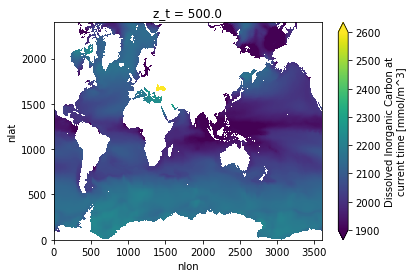

In [63]:
ds_out.DIC.isel(z_t=0).plot(vmin=1900,vmax=2600);

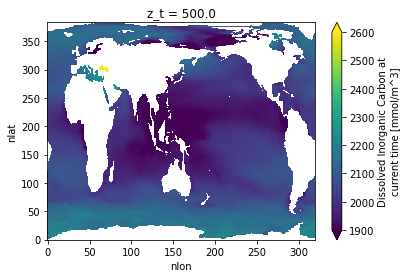

In [64]:
ds_refcase.DIC_CUR.where(MASK_refcase==1).isel(z_t=0).plot(vmin=1900,vmax=2600);

#### plot DIC at 1000m

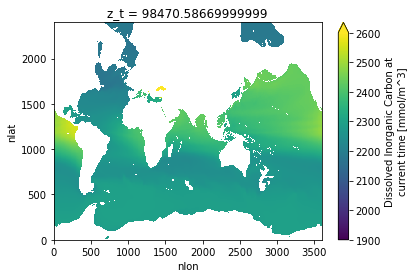

In [65]:
ds_out.DIC.isel(z_t=39).plot(vmin=1900,vmax=2600);

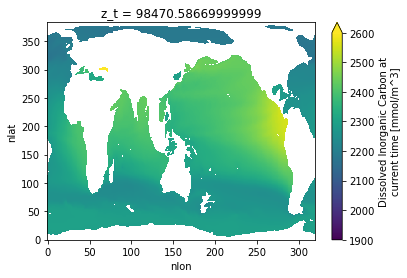

In [66]:
ds_refcase.DIC_CUR.where(MASK_refcase==1).isel(z_t=39).plot(vmin=1900,vmax=2600);

#### Make sure that bottom layer of ds_out has some values

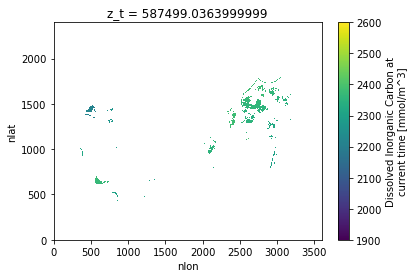

In [67]:
ds_out.DIC.isel(z_t=61).plot(vmin=1900,vmax=2600);

#### transect up the Pacific

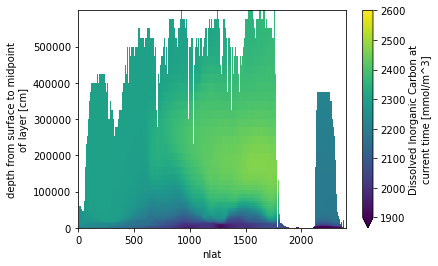

In [68]:
ds_out.DIC.isel(nlon=3000).plot(vmin=1900,vmax=2600);

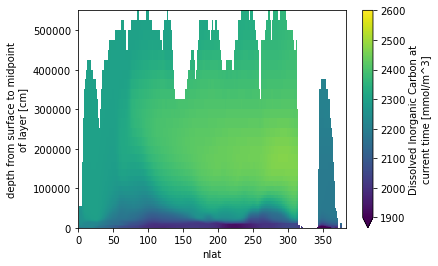

In [70]:
ds_refcase.DIC_CUR.where(MASK_refcase==1).isel(nlon=210).plot(vmin=1900,vmax=2600);